In [1]:
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_may9_649pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
platform = 'ig' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['lr','rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

report_sample_size = False # simple reporting feature

load_from_pickle = False # loads entire data dict, including masters, from pickle file

final_pickle = False # pickles entire data dict after all masters are created

populate_wordfeats_db = False # generates word features from reagan code

run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : False, 
    'density' : True, 
    'ml' : True, 
    'nhst' : True, 
    'corr' : True, 
    'print_corrmat' : True,
    'tall_plot': True
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test)

In [5]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

## Load ready data, or prepare raw data

Set load_from_pickle to determine action here.  

In case you don't have a pickled data dict, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle

In [6]:
if load_from_pickle:
    data = pickle.load( open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "rb" ) )
    
else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, periods, turn_points)
    pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )
    

TARGET DATA:
Shape of consolidated TARGET RATINGS data: (22860, 17)
Shape of consolidated TARGET ALL data: (22860, 20)

('Subset shape for IG BEFORE FROM_DIAG:', (12643, 20))
('Subset shape for IG BEFORE FROM_SUSP:', (2539, 20))
('Subset shape for IG AFTER FROM_DIAG:', (10214, 20))
('Subset shape for IG AFTER FROM_SUSP:', (4407, 20))

CONTROL DATA:
Shape of consolidated CONTROL RATINGS data: (22338, 17)
Shape of consolidated CONTROL ALL data: (22338, 20)



## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST


Merge to master: MAIN post
master post shape: (13269, 14)

target vs control for IG POST-groupby:


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


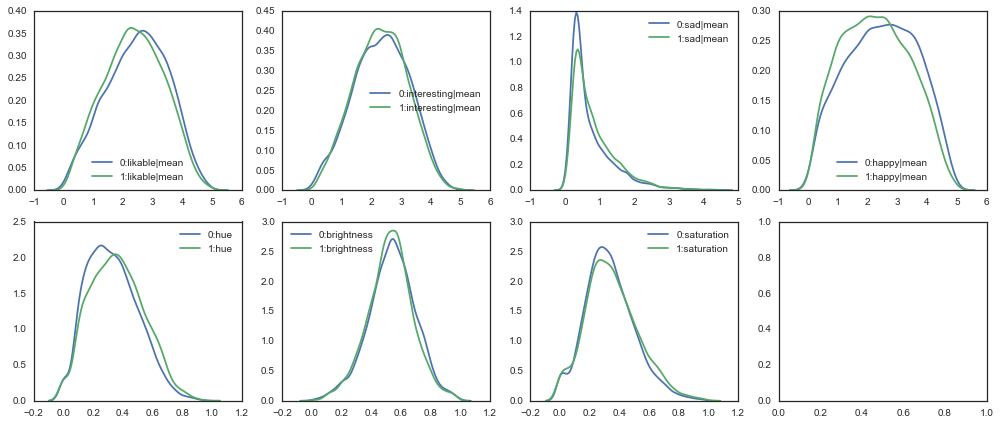

Correlation matrix:


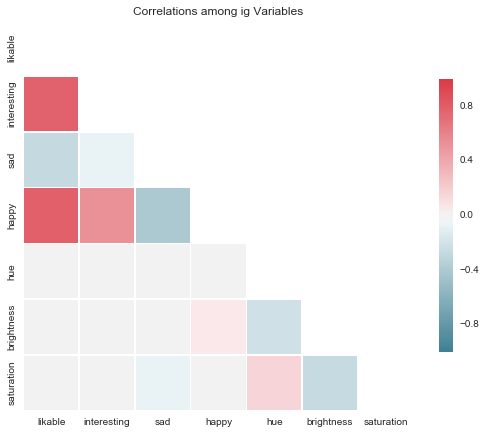

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.27   0.79 -0.00        0.03       -0.01
interesting     0.78         1.00 -0.07   0.53 -0.01        0.02       -0.02
sad            -0.27        -0.07  1.00  -0.40 -0.02       -0.03       -0.07
happy           0.79         0.53 -0.40   1.00  0.01        0.05        0.02
hue            -0.00        -0.01 -0.02   0.01  1.00       -0.21        0.16
brightness      0.03         0.02 -0.03   0.05 -0.21        1.00       -0.26
saturation     -0.01        -0.02 -0.07   0.02  0.16       -0.26        1.00
Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.548
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN post):
NAIVE ACCURACY: 0.553

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1260          922
known_target            858          9

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


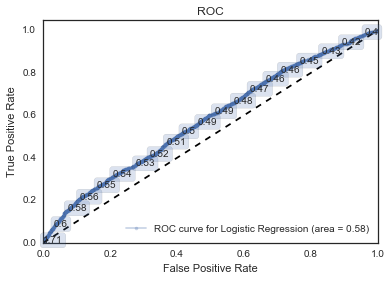

MODEL: Random Forests target (Models: MAIN post):
NAIVE ACCURACY: 0.562

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1456          726
known_target           1019          780

Proportion of pred_target in known_control: 0.333
Proportion of pred_target in known_target: 0.434




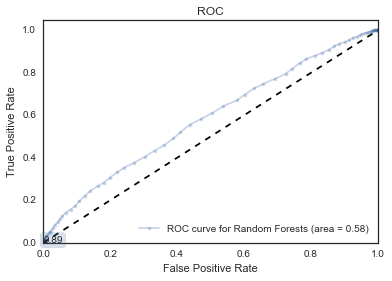

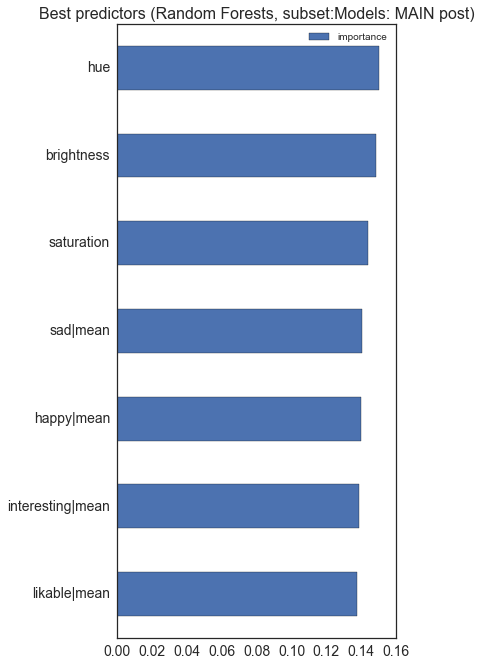

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=6.4345453516279392, pvalue=1.2809872397304595e-10)

RATING: interesting|mean
Ttest_indResult(statistic=1.8576845238616806, pvalue=0.063235972066287394)

RATING: sad|mean
Ttest_indResult(statistic=-8.1042281542913805, pvalue=5.7706677223957425e-16)

RATING: happy|mean
Ttest_indResult(statistic=10.376805033287592, pvalue=3.9458902989606649e-25)

RATING: hue
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? True (8.96691067811e-10)
interesting|mean significant post-correction? False (0.442651804464)
sad|mean significant post-correction? True (4.03946740568e-15)
happy|mean significant post-correction? True (2.76212320927e-24)
hue significant post-correction? False (nan)
brightness significant post-correcti

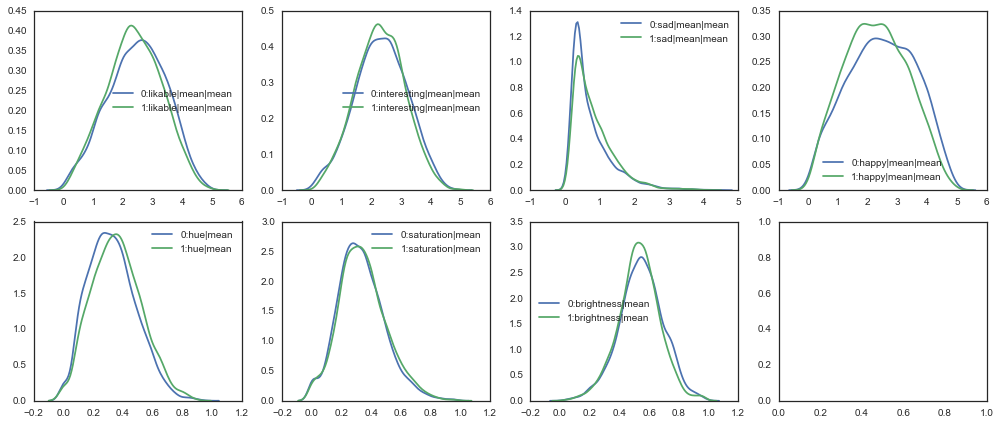

Correlation matrix:


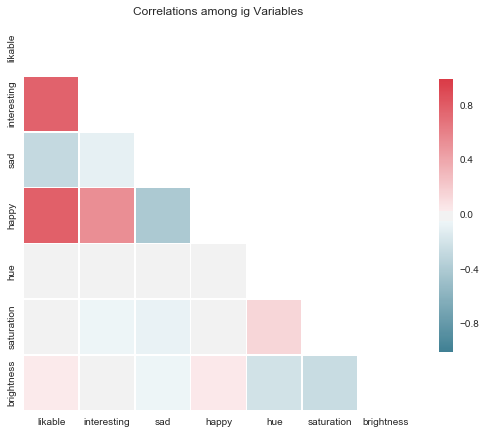

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.27   0.79 -0.00       -0.02        0.04
interesting     0.78         1.00 -0.08   0.54 -0.03       -0.04        0.03
sad            -0.27        -0.08  1.00  -0.40 -0.02       -0.07       -0.04
happy           0.79         0.54 -0.40   1.00  0.02        0.02        0.05
hue            -0.00        -0.03 -0.02   0.02  1.00        0.15       -0.20
saturation     -0.02        -0.04 -0.07   0.02  0.15        1.00       -0.25
brightness      0.04         0.03 -0.04   0.05 -0.20       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.562
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN created_date):
NAIVE ACCURACY: 0.56

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           863          663
known_target           

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


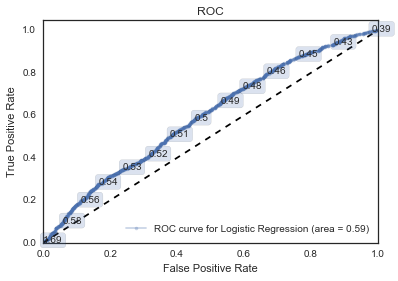

MODEL: Random Forests target (Models: MAIN created_date):
NAIVE ACCURACY: 0.582

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1172          354
known_target            781          406

Proportion of pred_target in known_control: 0.232
Proportion of pred_target in known_target: 0.342




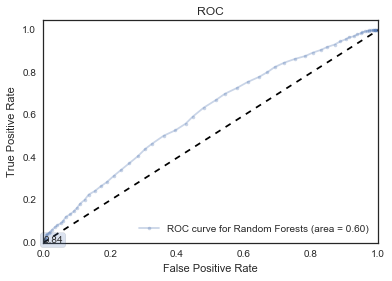

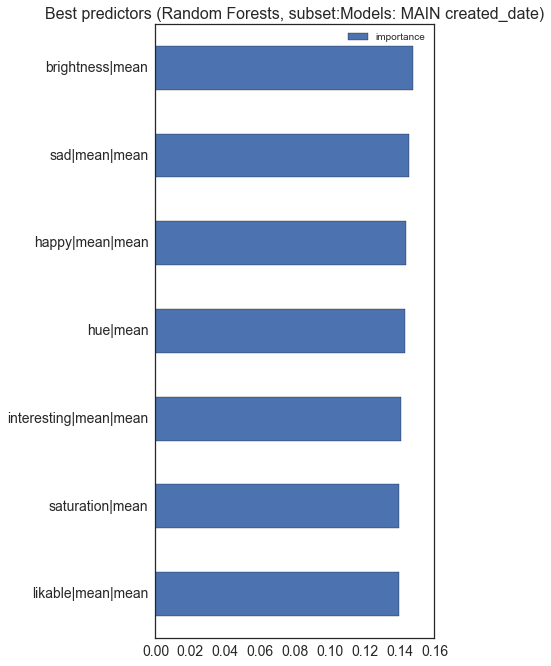

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=5.0739573376325229, pvalue=3.9737661287200736e-07)

RATING: interesting|mean|mean
Ttest_indResult(statistic=2.000723558379685, pvalue=0.045452037876757466)

RATING: sad|mean|mean
Ttest_indResult(statistic=-6.1432901608072816, pvalue=8.4242107113156352e-10)

RATING: happy|mean|mean
Ttest_indResult(statistic=8.2948289995211404, pvalue=1.2434281204968773e-16)

RATING: hue|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness|mean
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? True (2.7816362901e-06)
interesting|mean|mean significant post-correction? False (0.318164265137)
sad|mean|mean significant post-correction? True (5.89694749792e-09)
happy|mean|mean significant post-correction? True (8.70399684348e-16)
hue|mean significant

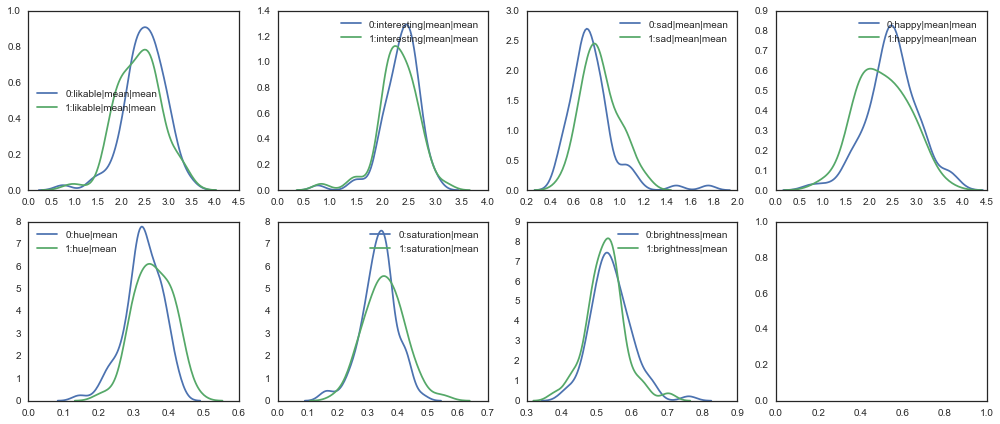

Correlation matrix:


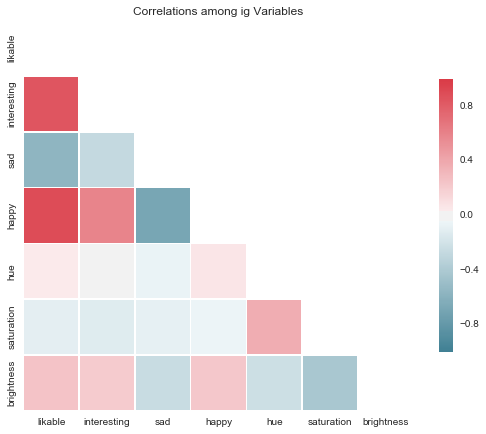

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.85 -0.56   0.90  0.04       -0.10        0.25
interesting     0.85         1.00 -0.27   0.60 -0.01       -0.12        0.21
sad            -0.56        -0.27  1.00  -0.68 -0.06       -0.08       -0.25
happy           0.90         0.60 -0.68   1.00  0.07       -0.05        0.23
hue             0.04        -0.01 -0.06   0.07  1.00        0.37       -0.22
saturation     -0.10        -0.12 -0.08  -0.05  0.37        1.00       -0.42
brightness      0.25         0.21 -0.25   0.23 -0.22       -0.42        1.00
Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.55
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN username):
NAIVE ACCURACY: 0.575

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            13            9
known_target              8    

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


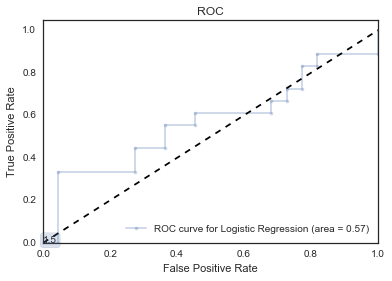

MODEL: Random Forests target (Models: MAIN username):
NAIVE ACCURACY: 0.475

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            17            5
known_target             16            2

Proportion of pred_target in known_control: 0.227
Proportion of pred_target in known_target: 0.111




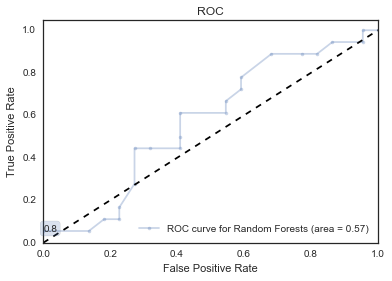

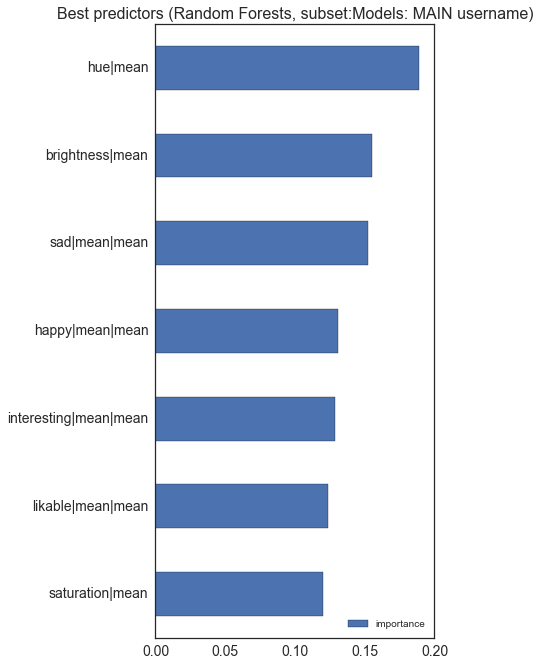

UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=1.5165575445158432, pvalue=0.13178785352597505)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.89537837228769812, pvalue=0.37222712968055605)

RATING: sad|mean|mean
Ttest_indResult(statistic=-2.1381698183958617, pvalue=0.034359324756836583)

RATING: happy|mean|mean
Ttest_indResult(statistic=1.9497827833575683, pvalue=0.053338144214065637)

RATING: hue|mean
Ttest_indResult(statistic=-3.0575230037046071, pvalue=0.0027060845551903079)

RATING: saturation|mean
Ttest_indResult(statistic=-1.7169578982852161, pvalue=0.088350208227846602)

RATING: brightness|mean
Ttest_indResult(statistic=1.5856192929344395, pvalue=0.11523670495360215)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (0.922514974682)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? False (0.240515273298)
happy|mean|mean 

In [7]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'

    if action_params['create_master']:
        master['model'] = {}

    for gb_type in gb_types:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs)

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: POST

Merge to master: before from_diag post
master post shape: (10539, 14)

target vs control for IG POST-groupby:


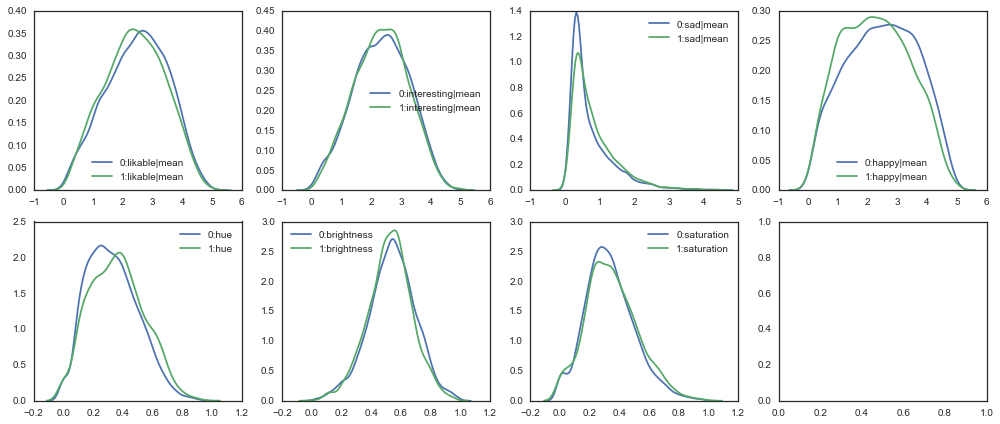

Correlation matrix:


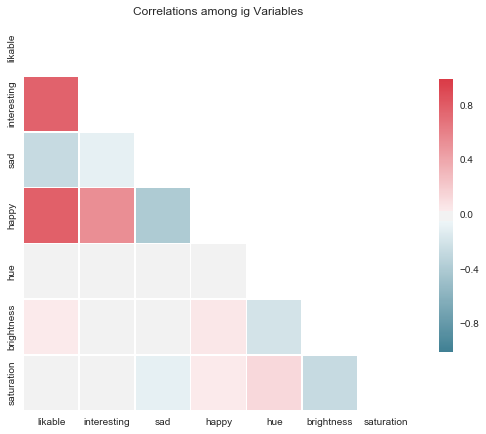

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.26   0.79  0.00        0.04       -0.01
interesting     0.78         1.00 -0.08   0.54 -0.01        0.02       -0.02
sad            -0.26        -0.08  1.00  -0.39 -0.03       -0.02       -0.08
happy           0.79         0.54 -0.39   1.00  0.01        0.06        0.04
hue             0.00        -0.01 -0.03   0.01  1.00       -0.19        0.14
brightness      0.04         0.02 -0.02   0.06 -0.19        1.00       -0.26
saturation     -0.01        -0.02 -0.08   0.04  0.14       -0.26        1.00
Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.696
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag post):
NAIVE ACCURACY: 0.55

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1237          963
known_target            459

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


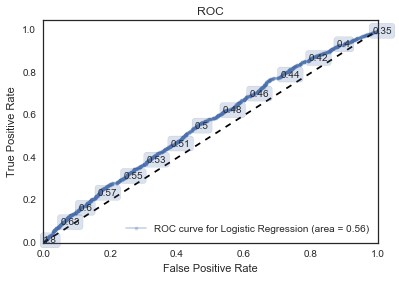

MODEL: Random Forests target (Models: before from_diag post):
NAIVE ACCURACY: 0.671

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1998          202
known_target            838          124

Proportion of pred_target in known_control: 0.092
Proportion of pred_target in known_target: 0.129




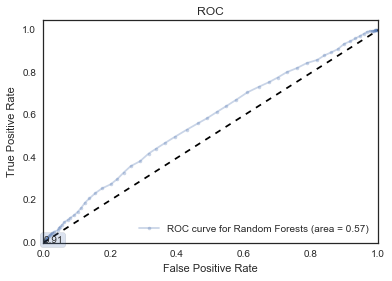

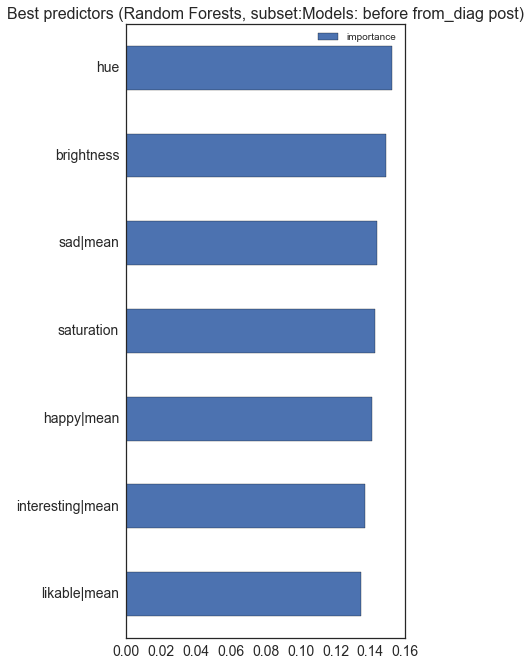

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=4.039132049732217, pvalue=5.4029876305817461e-05)

RATING: interesting|mean
Ttest_indResult(statistic=0.67602856811356449, pvalue=0.4990373483710645)

RATING: sad|mean
Ttest_indResult(statistic=-6.569755753015813, pvalue=5.2778532312170903e-11)

RATING: happy|mean
Ttest_indResult(statistic=8.4187396399911947, pvalue=4.2998615965545785e-17)

RATING: hue
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? True (0.000378209134141)
interesting|mean significant post-correction? False (1.0)
sad|mean significant post-correction? True (3.69449726185e-10)
happy|mean significant post-correction? True (3.00990311759e-16)
hue significant post-correction? False (nan)
brightness significant post-correction? False (nan

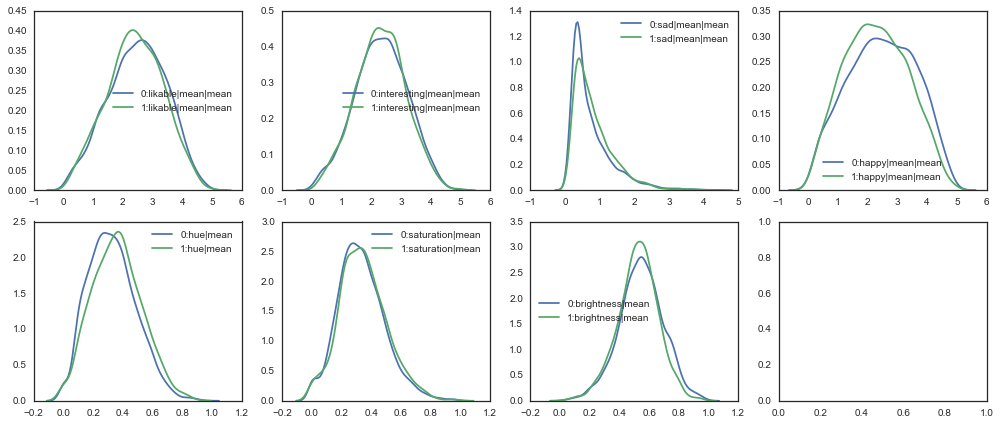

Correlation matrix:


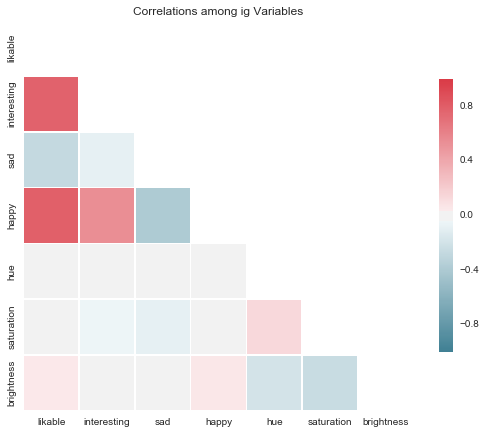

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.27   0.79 -0.00       -0.02        0.05
interesting     0.78         1.00 -0.08   0.54 -0.03       -0.04        0.03
sad            -0.27        -0.08  1.00  -0.39 -0.03       -0.08       -0.03
happy           0.79         0.54 -0.39   1.00  0.02        0.03        0.06
hue            -0.00        -0.03 -0.03   0.02  1.00        0.14       -0.19
saturation     -0.02        -0.04 -0.08   0.03  0.14        1.00       -0.25
brightness      0.05         0.03 -0.03   0.06 -0.19       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.709
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag created_date):
NAIVE ACCURACY: 0.549

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           873          676
known_targ

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


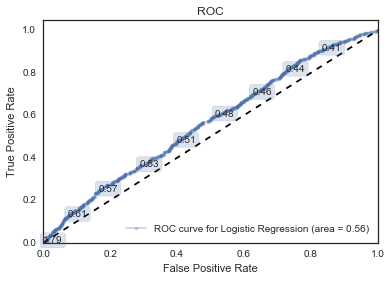

MODEL: Random Forests target (Models: before from_diag created_date):
NAIVE ACCURACY: 0.691

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1445          104
known_target            571           66

Proportion of pred_target in known_control: 0.067
Proportion of pred_target in known_target: 0.104




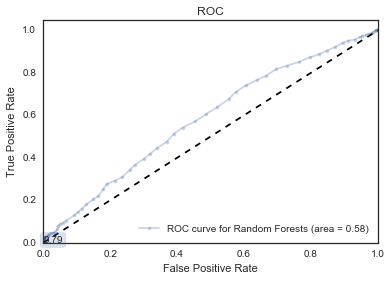

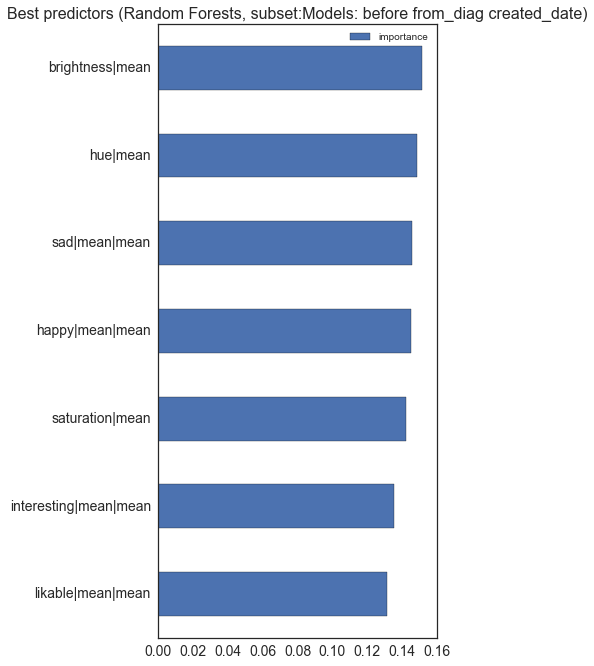

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=2.9193320785492629, pvalue=0.0035185707312318424)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.76956786098186225, pvalue=0.4415812336450653)

RATING: sad|mean|mean
Ttest_indResult(statistic=-4.7877860120299598, pvalue=1.7196107624467248e-06)

RATING: happy|mean|mean
Ttest_indResult(statistic=6.697159151142011, pvalue=2.2833919002237935e-11)

RATING: hue|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness|mean
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? True (0.0246299951186)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? True (1.20372753371e-05)
happy|mean|mean significant post-correction? True (1.59837433016e-10)
hue|mean significant post-correcti

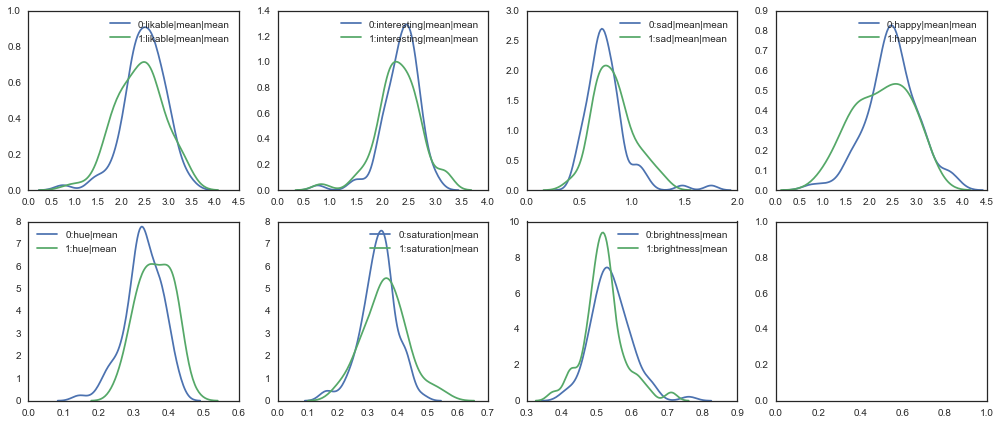

Correlation matrix:


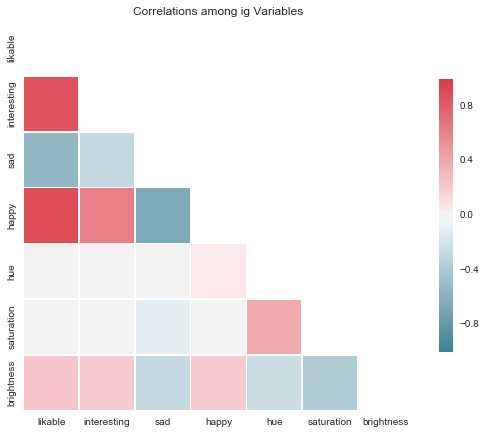

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.54   0.90  0.01       -0.00        0.24
interesting     0.86         1.00 -0.28   0.62 -0.02       -0.02        0.21
sad            -0.54        -0.28  1.00  -0.65 -0.00       -0.10       -0.27
happy           0.90         0.62 -0.65   1.00  0.05        0.03        0.21
hue             0.01        -0.02 -0.00   0.05  1.00        0.39       -0.24
saturation     -0.00        -0.02 -0.10   0.03  0.39        1.00       -0.37
brightness      0.24         0.21 -0.27   0.21 -0.24       -0.37        1.00
Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.775
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag username):
NAIVE ACCURACY: 0.6

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            20           11
known_target        

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


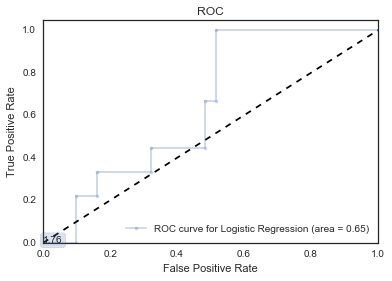

MODEL: Random Forests target (Models: before from_diag username):
NAIVE ACCURACY: 0.6

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            20           11
known_target              5            4

Proportion of pred_target in known_control: 0.355
Proportion of pred_target in known_target: 0.444




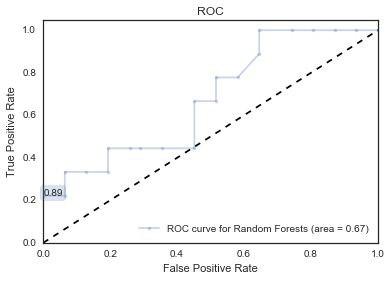

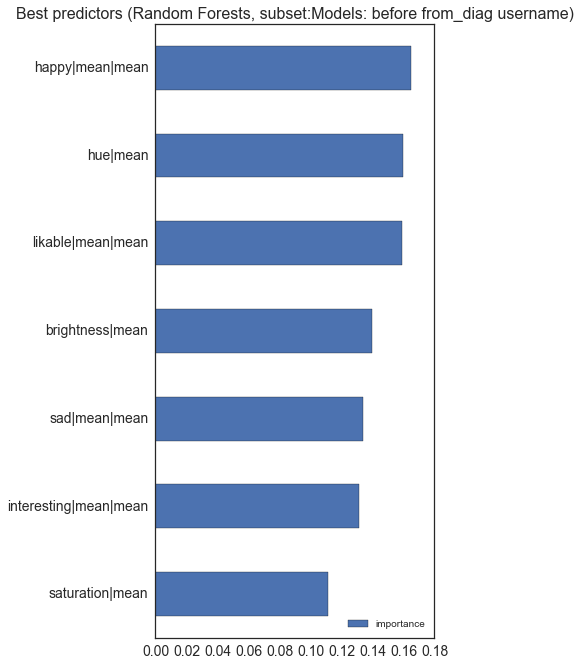

UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=1.2743014957518335, pvalue=0.20481250322112654)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.65843482810032938, pvalue=0.51141430149568423)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.9415717232191394, pvalue=0.054335696814878473)

RATING: happy|mean|mean
Ttest_indResult(statistic=2.1015946877919087, pvalue=0.037504035090256689)

RATING: hue|mean
Ttest_indResult(statistic=-3.6357388794483394, pvalue=0.00039709452945728939)

RATING: saturation|mean
Ttest_indResult(statistic=-1.9046730531041887, pvalue=0.059014894412708088)

RATING: brightness|mean
Ttest_indResult(statistic=2.0468657983731156, pvalue=0.042671008228379811)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? False (0.380349877704)
happy|mean|mean significa

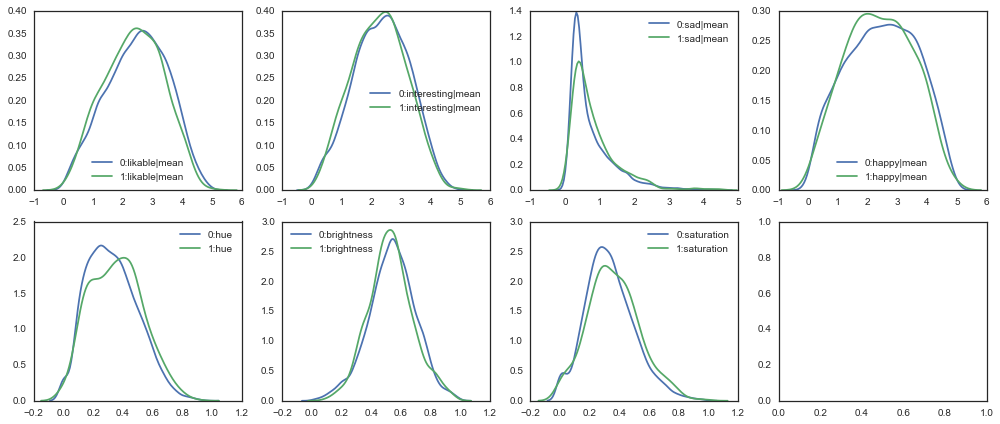

Correlation matrix:


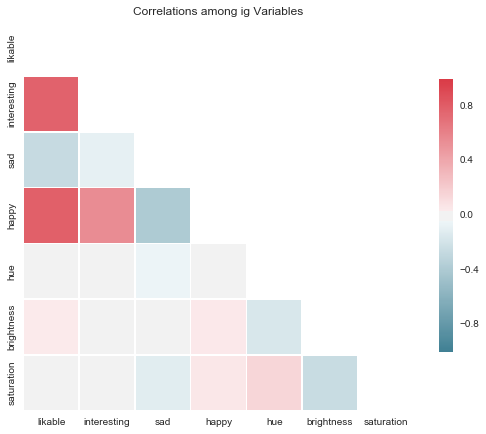

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.26   0.79  0.01        0.04        0.02
interesting     0.78         1.00 -0.08   0.55  0.00        0.02        0.00
sad            -0.26        -0.08  1.00  -0.39 -0.05       -0.01       -0.11
happy           0.79         0.55 -0.39   1.00  0.03        0.05        0.06
hue             0.01         0.00 -0.05   0.03  1.00       -0.16        0.15
brightness      0.04         0.02 -0.01   0.05 -0.16        1.00       -0.25
saturation      0.02         0.00 -0.11   0.06  0.15       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.916
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp post):
NAIVE ACCURACY: 0.575

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1239          920
known_target             8

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


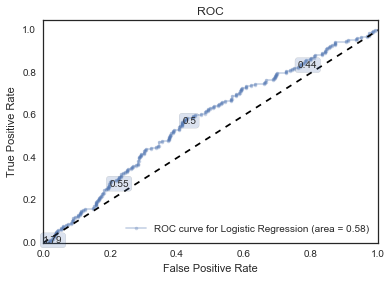

MODEL: Random Forests target (Models: before from_susp post):
NAIVE ACCURACY: 0.915

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2158            1
known_target            199            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




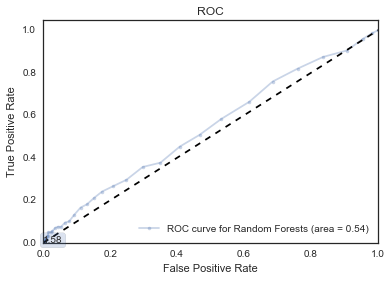

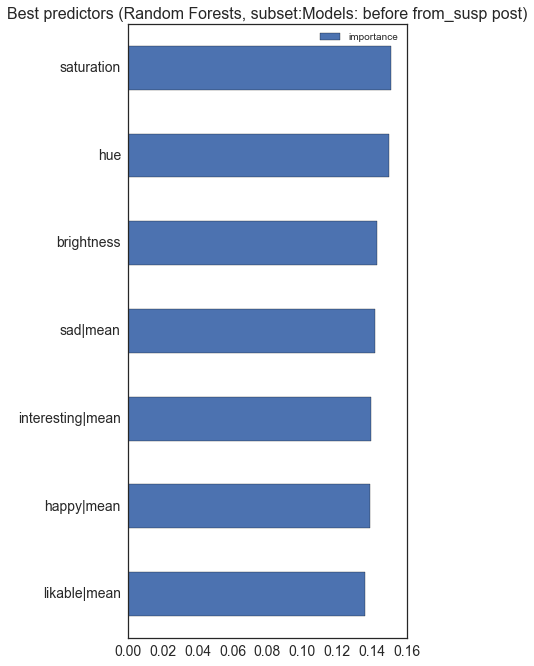

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=2.9577866877759704, pvalue=0.0031077982951934423)

RATING: interesting|mean
Ttest_indResult(statistic=2.1866009622142806, pvalue=0.02880107845167364)

RATING: sad|mean
Ttest_indResult(statistic=-3.3827625742236225, pvalue=0.00072111684871956126)

RATING: happy|mean
Ttest_indResult(statistic=1.7583338885959714, pvalue=0.078729708160890186)

RATING: hue
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? True (0.0217545880664)
interesting|mean significant post-correction? False (0.201607549162)
sad|mean significant post-correction? True (0.00504781794104)
happy|mean significant post-correction? False (0.551107957126)
hue significant post-correction? False (nan)
brightness significant post-correction? False

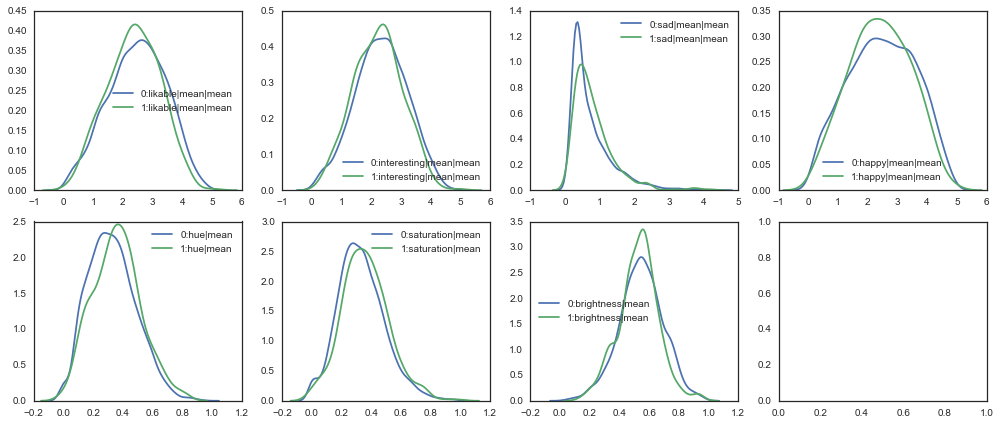

Correlation matrix:


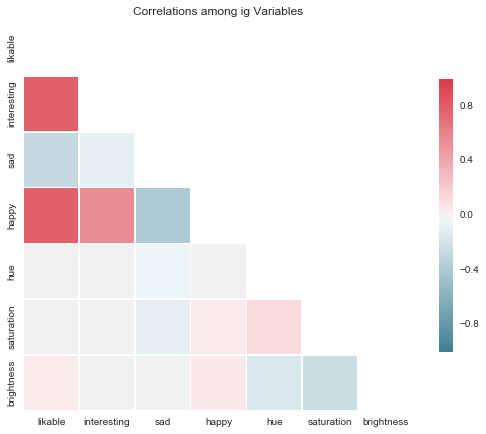

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.79 -0.27   0.79  0.02        0.00        0.04
interesting     0.79         1.00 -0.08   0.55 -0.01       -0.02        0.03
sad            -0.27        -0.08  1.00  -0.39 -0.04       -0.09       -0.02
happy           0.79         0.55 -0.39   1.00  0.03        0.04        0.05
hue             0.02        -0.01 -0.04   0.03  1.00        0.13       -0.16
saturation      0.00        -0.02 -0.09   0.04  0.13        1.00       -0.25
brightness      0.04         0.03 -0.02   0.05 -0.16       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.929
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp created_date):
NAIVE ACCURACY: 0.575

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           887          649
known_targ

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


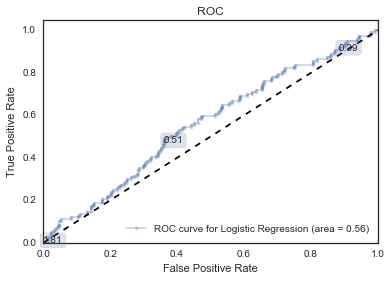

MODEL: Random Forests target (Models: before from_susp created_date):
NAIVE ACCURACY: 0.929

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1536            0
known_target            117            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




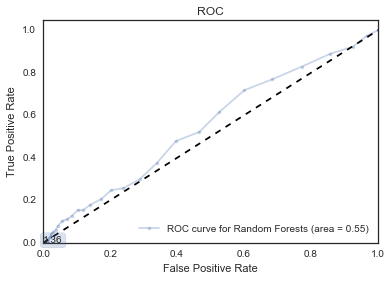

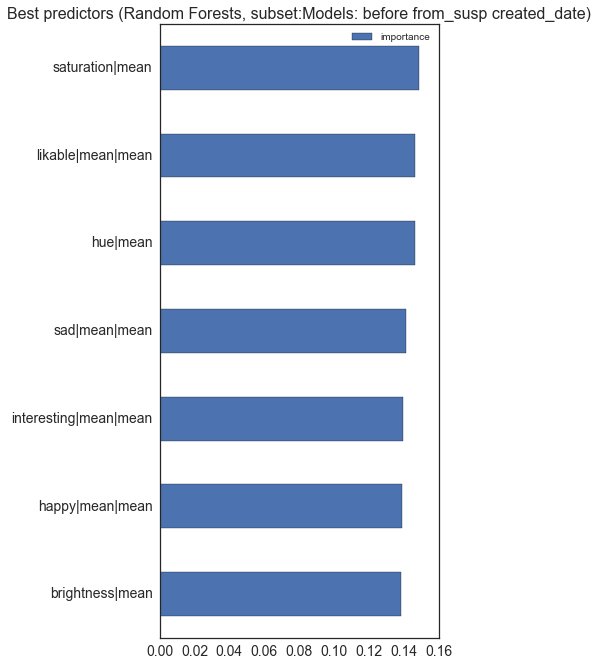

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=2.4285608246898929, pvalue=0.015190691712640651)

RATING: interesting|mean|mean
Ttest_indResult(statistic=2.378564782740499, pvalue=0.017414089773688704)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.9282202156387613, pvalue=0.053879128823658778)

RATING: happy|mean|mean
Ttest_indResult(statistic=1.1845193025518852, pvalue=0.23625871573722815)

RATING: hue|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness|mean
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (0.106334841988)
interesting|mean|mean significant post-correction? False (0.121898628416)
sad|mean|mean significant post-correction? False (0.377153901766)
happy|mean|mean significant post-correction? False (1.0)
hue|mean significant post-correction? False

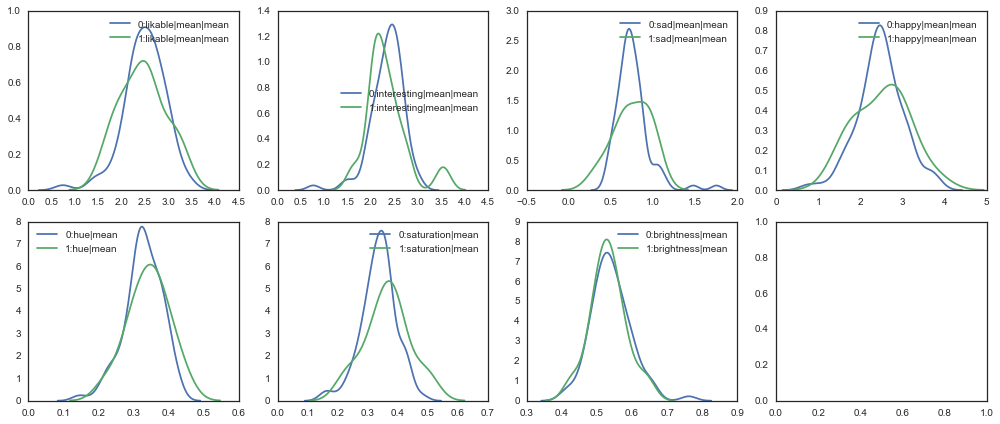

Correlation matrix:


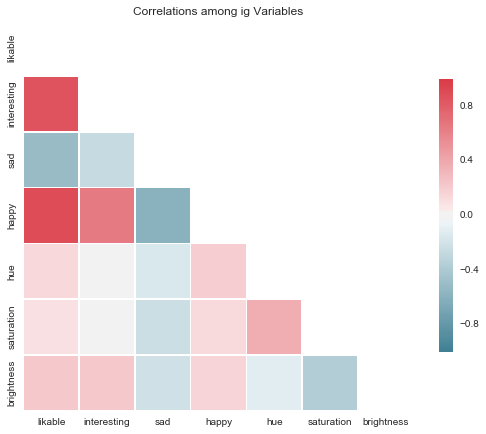

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.51   0.90  0.14        0.09        0.22
interesting     0.86         1.00 -0.26   0.65  0.03        0.01        0.22
sad            -0.51        -0.26  1.00  -0.59 -0.15       -0.23       -0.21
happy           0.90         0.65 -0.59   1.00  0.20        0.13        0.16
hue             0.14         0.03 -0.15   0.20  1.00        0.37       -0.11
saturation      0.09         0.01 -0.23   0.13  0.37        1.00       -0.36
brightness      0.22         0.22 -0.21   0.16 -0.11       -0.36        1.00
Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.793
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp username):
NAIVE ACCURACY: 0.724

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            20            3
known_target      

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


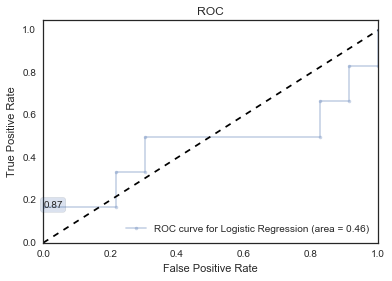

MODEL: Random Forests target (Models: before from_susp username):
NAIVE ACCURACY: 0.793

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            23            0
known_target              6            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




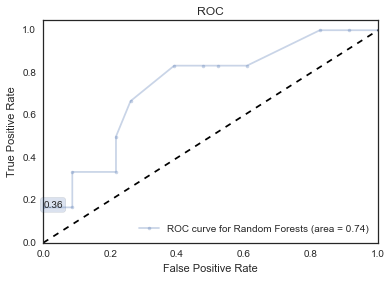

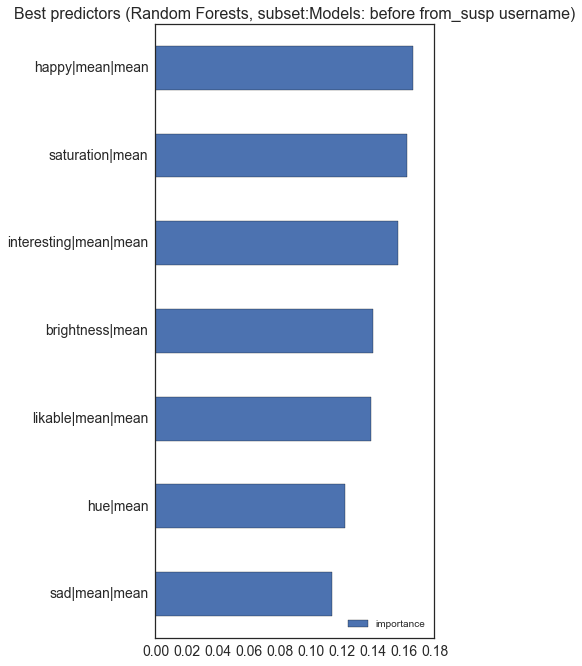

UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.31800124502076876, pvalue=0.75118937753641224)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.13218652853556548, pvalue=0.89511929350541508)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.13788971305250047, pvalue=0.89062252631801608)

RATING: happy|mean|mean
Ttest_indResult(statistic=-0.21118524391633683, pvalue=0.83319989356148538)

RATING: hue|mean
Ttest_indResult(statistic=-0.92456476556415168, pvalue=0.35755976126563005)

RATING: saturation|mean
Ttest_indResult(statistic=-1.5797948126815446, pvalue=0.11751315813434206)

RATING: brightness|mean
Ttest_indResult(statistic=0.51701894906916523, pvalue=0.60635733461072605)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean significant post-corre

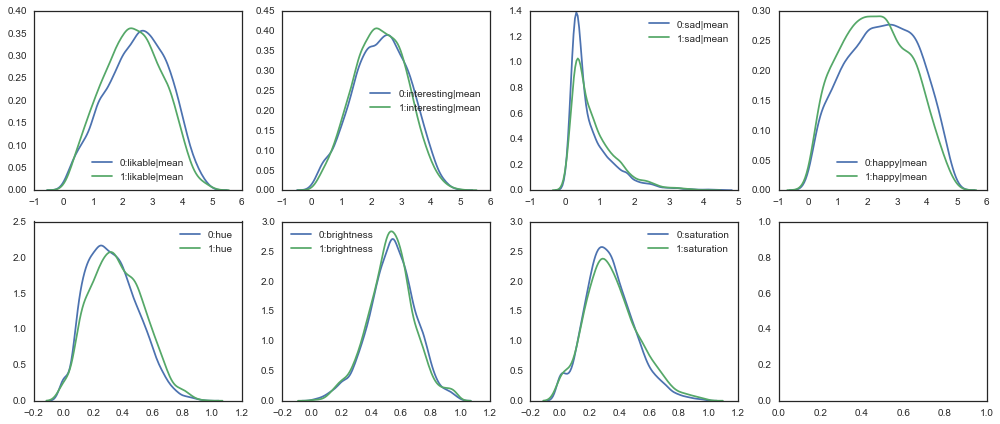

Correlation matrix:


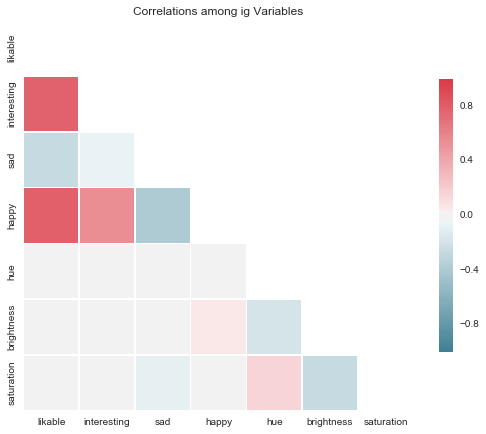

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.26   0.79  0.00        0.03       -0.00
interesting     0.78         1.00 -0.07   0.54 -0.01        0.02       -0.01
sad            -0.26        -0.07  1.00  -0.39 -0.03       -0.02       -0.08
happy           0.79         0.54 -0.39   1.00  0.02        0.06        0.03
hue             0.00        -0.01 -0.03   0.02  1.00       -0.18        0.16
brightness      0.03         0.02 -0.02   0.06 -0.18        1.00       -0.26
saturation     -0.00        -0.01 -0.08   0.03  0.16       -0.26        1.00
Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.728
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag post):
NAIVE ACCURACY: 0.568

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1258          909
known_target            378

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


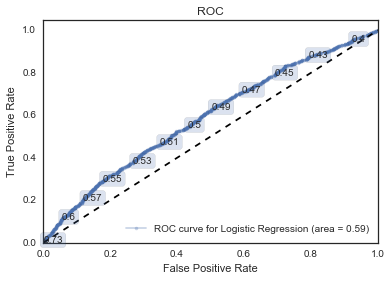

MODEL: Random Forests target (Models: after from_diag post):
NAIVE ACCURACY: 0.727

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2118           49
known_target            762           47

Proportion of pred_target in known_control: 0.023
Proportion of pred_target in known_target: 0.058




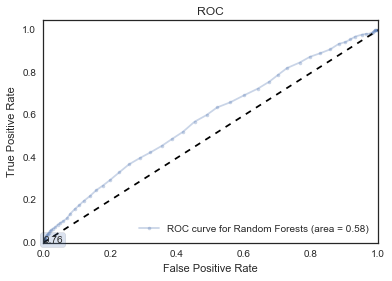

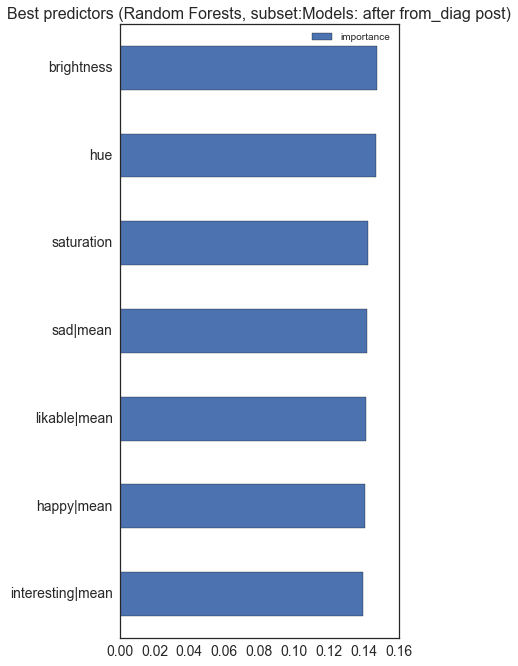

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=6.446369184848634, pvalue=1.1989270089849748e-10)

RATING: interesting|mean
Ttest_indResult(statistic=2.4171094346329274, pvalue=0.015662240235117617)

RATING: sad|mean
Ttest_indResult(statistic=-6.4994578186002112, pvalue=8.4489484080397441e-11)

RATING: happy|mean
Ttest_indResult(statistic=8.1899736205834586, pvalue=2.9352712297265689e-16)

RATING: hue
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? True (8.39248906289e-10)
interesting|mean significant post-correction? False (0.109635681646)
sad|mean significant post-correction? True (5.91426388563e-10)
happy|mean significant post-correction? True (2.05468986081e-15)
hue significant post-correction? False (nan)
brightness significant post-correctio

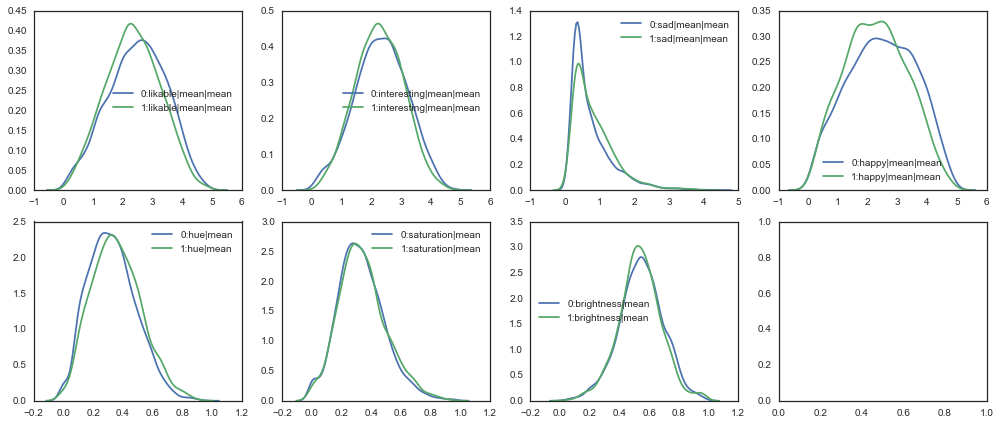

Correlation matrix:


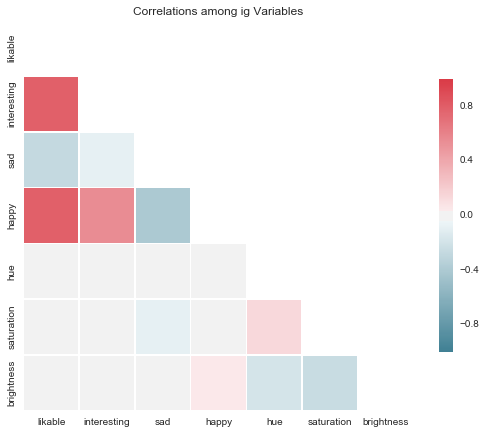

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.79 -0.27   0.79  0.01       -0.01        0.03
interesting     0.79         1.00 -0.08   0.55 -0.02       -0.03        0.02
sad            -0.27        -0.08  1.00  -0.40 -0.03       -0.08       -0.03
happy           0.79         0.55 -0.40   1.00  0.03        0.03        0.05
hue             0.01        -0.02 -0.03   0.03  1.00        0.14       -0.18
saturation     -0.01        -0.03 -0.08   0.03  0.14        1.00       -0.25
brightness      0.03         0.02 -0.03   0.05 -0.18       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.746
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag created_date):
NAIVE ACCURACY: 0.575

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           917          620
known_targe

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


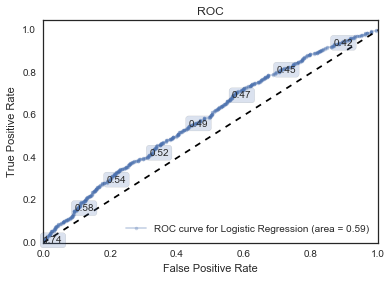

MODEL: Random Forests target (Models: after from_diag created_date):
NAIVE ACCURACY: 0.746

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1506           31
known_target            492           30

Proportion of pred_target in known_control: 0.02
Proportion of pred_target in known_target: 0.057




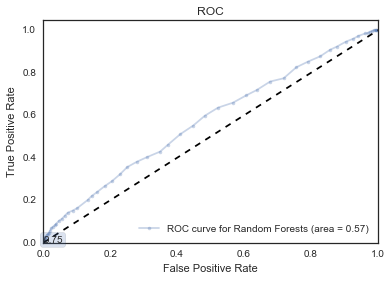

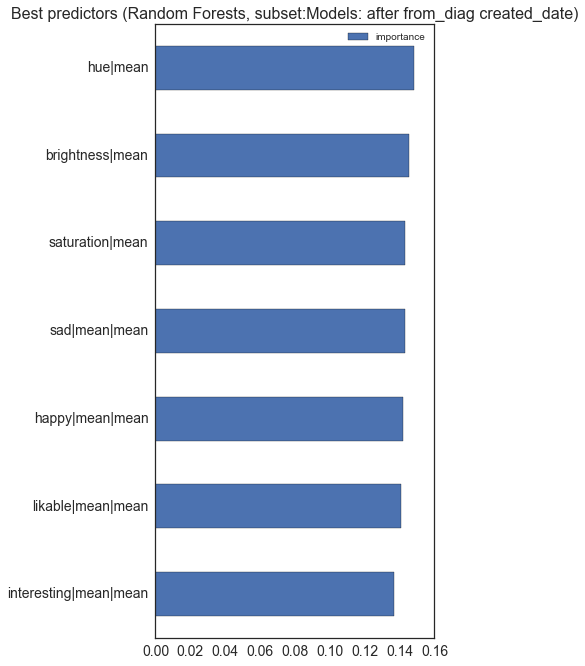

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=5.3072677046507897, pvalue=1.1476829037858726e-07)

RATING: interesting|mean|mean
Ttest_indResult(statistic=2.5276706255627239, pvalue=0.011504471444583012)

RATING: sad|mean|mean
Ttest_indResult(statistic=-5.0100305530035367, pvalue=5.5783313941178741e-07)

RATING: happy|mean|mean
Ttest_indResult(statistic=6.4084296962073672, pvalue=1.5677646046076336e-10)

RATING: hue|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness|mean
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? True (8.0337803265e-07)
interesting|mean|mean significant post-correction? False (0.0805313001121)
sad|mean|mean significant post-correction? True (3.90483197588e-06)
happy|mean|mean significant post-correction? True (1.09743522323e-09)
hue|mean significa

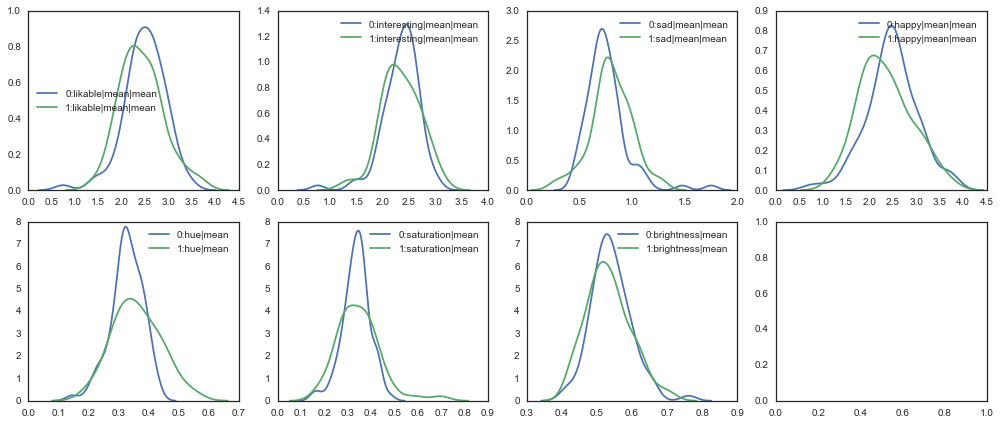

Correlation matrix:


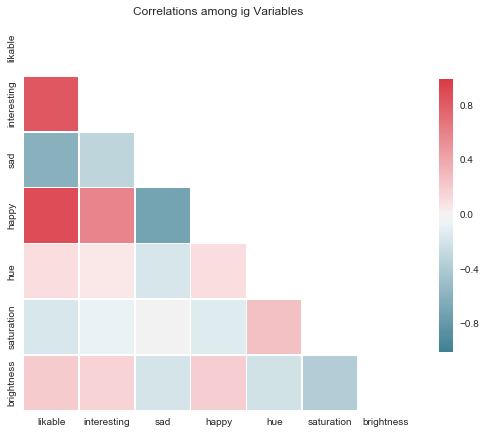

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.84 -0.60   0.90  0.11       -0.16        0.21
interesting     0.84         1.00 -0.30   0.60  0.06       -0.07        0.17
sad            -0.60        -0.30  1.00  -0.71 -0.17       -0.02       -0.18
happy           0.90         0.60 -0.71   1.00  0.11       -0.12        0.20
hue             0.11         0.06 -0.17   0.11  1.00        0.27       -0.20
saturation     -0.16        -0.07 -0.02  -0.12  0.27        1.00       -0.36
brightness      0.21         0.17 -0.18   0.20 -0.20       -0.36        1.00
Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.725
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag username):
NAIVE ACCURACY: 0.5

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            13           16
known_target         

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


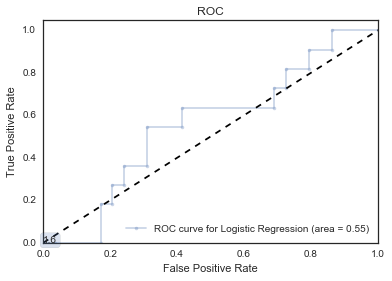

MODEL: Random Forests target (Models: after from_diag username):
NAIVE ACCURACY: 0.725

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            24            5
known_target              6            5

Proportion of pred_target in known_control: 0.172
Proportion of pred_target in known_target: 0.455




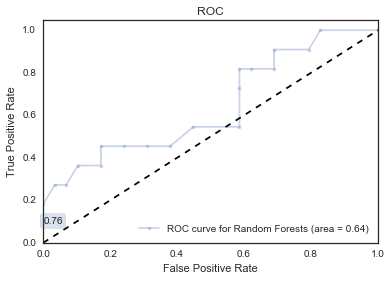

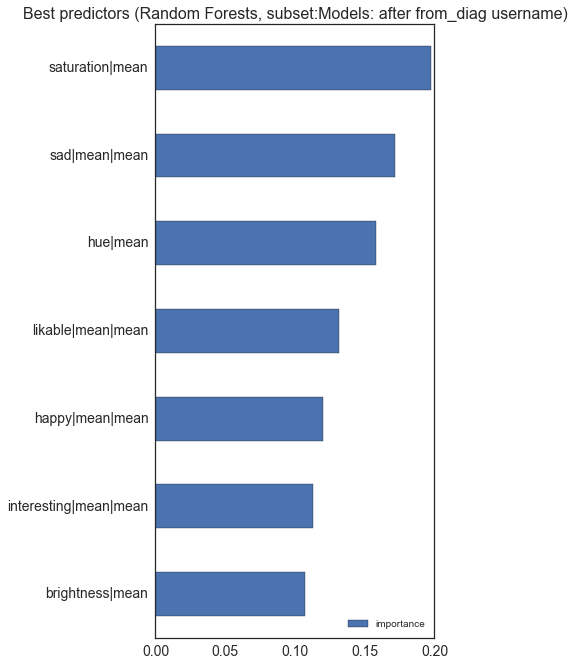

UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.82119136654219349, pvalue=0.41304067122177879)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.10860833751481432, pvalue=0.91368060560422781)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.3042715948636898, pvalue=0.19444549856821289)

RATING: happy|mean|mean
Ttest_indResult(statistic=1.3590494892103133, pvalue=0.17648402355205073)

RATING: hue|mean
Ttest_indResult(statistic=-2.8687642854808013, pvalue=0.0048105144801689342)

RATING: saturation|mean
Ttest_indResult(statistic=-0.82417870376322389, pvalue=0.41134760017512262)

RATING: brightness|mean
Ttest_indResult(statistic=0.68112994821571271, pvalue=0.49700076721352571)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean significant post-corre

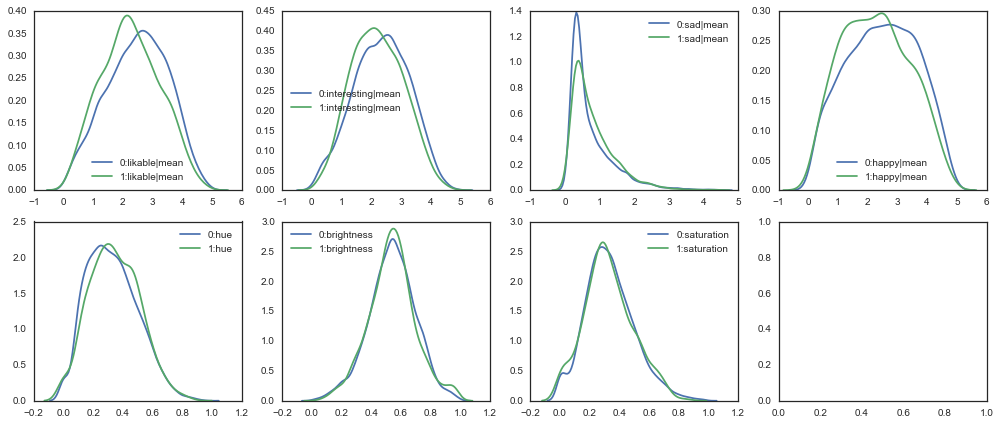

Correlation matrix:


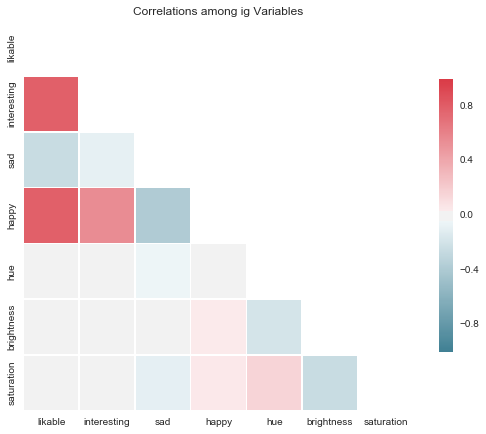

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.79 -0.25   0.79  0.01        0.03        0.01
interesting     0.79         1.00 -0.08   0.55 -0.01        0.02       -0.01
sad            -0.25        -0.08  1.00  -0.38 -0.04       -0.02       -0.09
happy           0.79         0.55 -0.38   1.00  0.03        0.04        0.05
hue             0.01        -0.01 -0.04   0.03  1.00       -0.18        0.16
brightness      0.03         0.02 -0.02   0.04 -0.18        1.00       -0.25
saturation      0.01        -0.01 -0.09   0.05  0.16       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.856
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp post):
NAIVE ACCURACY: 0.548

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1176          967
known_target            164

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


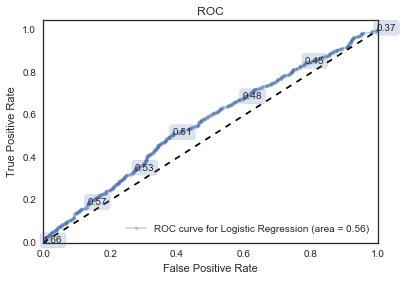

MODEL: Random Forests target (Models: after from_susp post):
NAIVE ACCURACY: 0.857

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2139            4
known_target            354            6

Proportion of pred_target in known_control: 0.002
Proportion of pred_target in known_target: 0.017




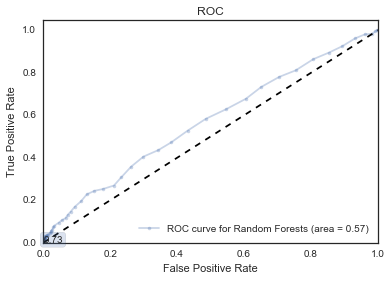

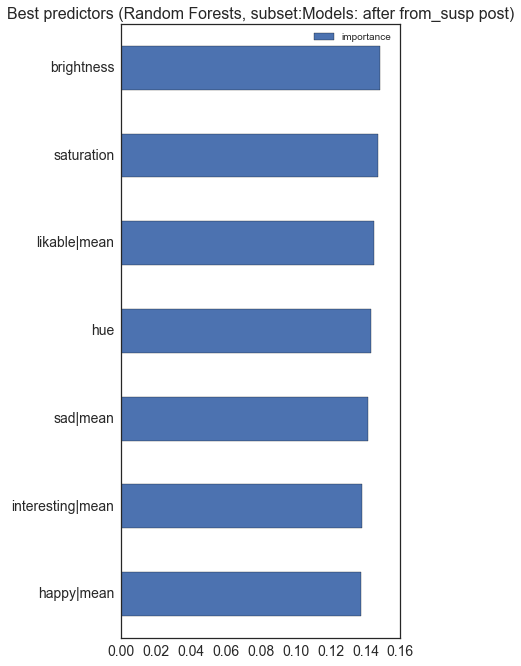

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=6.938119393561653, pvalue=4.2704210628650368e-12)

RATING: interesting|mean
Ttest_indResult(statistic=4.5372533048950787, pvalue=5.7789229241783381e-06)

RATING: sad|mean
Ttest_indResult(statistic=-3.2404069945674885, pvalue=0.0011982789825190855)

RATING: happy|mean
Ttest_indResult(statistic=5.4691887242774504, pvalue=4.6519535632052104e-08)

RATING: hue
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? True (2.98929474401e-11)
interesting|mean significant post-correction? True (4.04524604692e-05)
sad|mean significant post-correction? True (0.00838795287763)
happy|mean significant post-correction? True (3.25636749424e-07)
hue significant post-correction? False (nan)
brightness significant post-correct

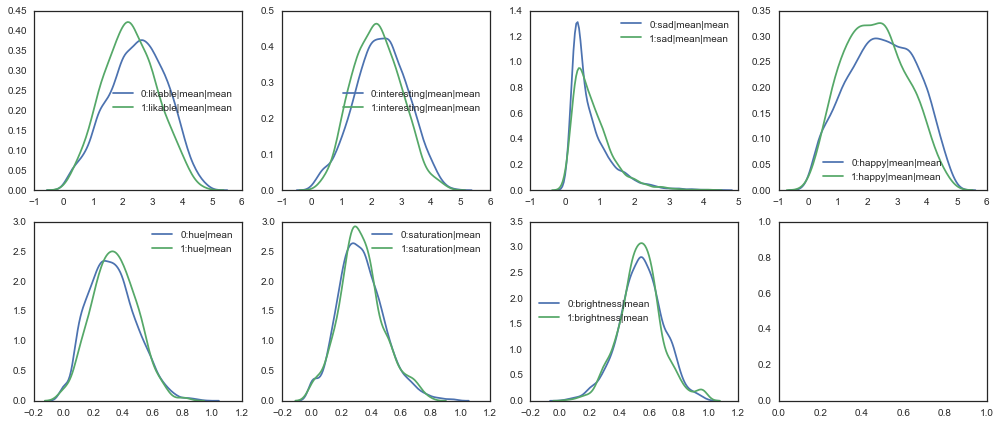

Correlation matrix:


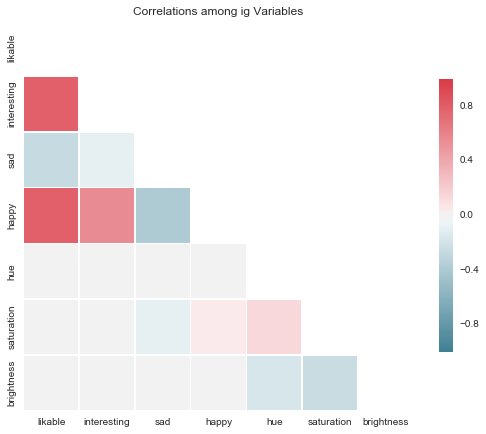

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.79 -0.26   0.79  0.01        0.00        0.03
interesting     0.79         1.00 -0.08   0.56 -0.02       -0.02        0.03
sad            -0.26        -0.08  1.00  -0.39 -0.03       -0.08       -0.02
happy           0.79         0.56 -0.39   1.00  0.03        0.04        0.03
hue             0.01        -0.02 -0.03   0.03  1.00        0.14       -0.17
saturation      0.00        -0.02 -0.08   0.04  0.14        1.00       -0.25
brightness      0.03         0.03 -0.02   0.03 -0.17       -0.25        1.00
Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.881
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp created_date):
NAIVE ACCURACY: 0.556

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           860          684
known_targe

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


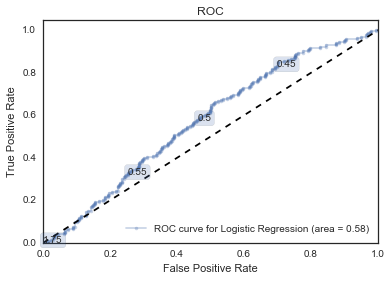

MODEL: Random Forests target (Models: after from_susp created_date):
NAIVE ACCURACY: 0.879

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1541            3
known_target            209            0

Proportion of pred_target in known_control: 0.002
Proportion of pred_target in known_target: 0.0




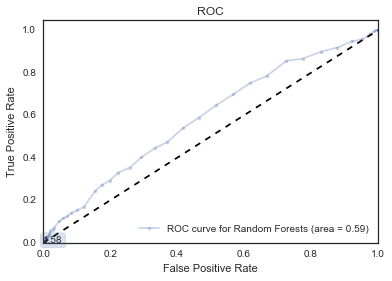

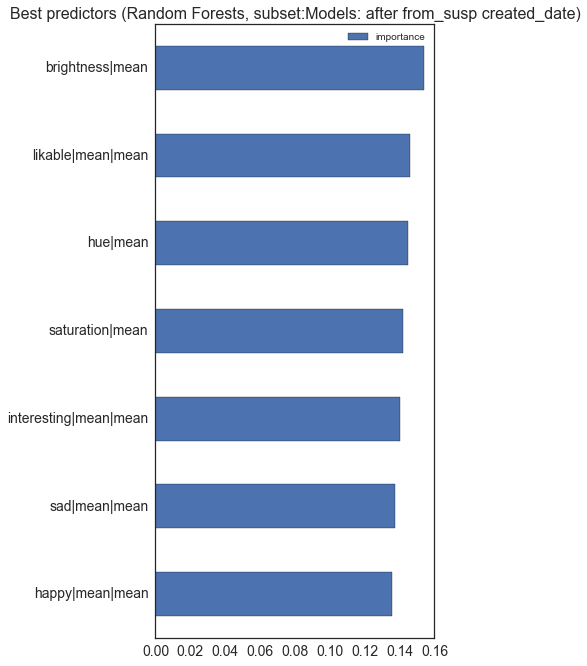

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=6.3091283543403351, pvalue=3.0122335495678284e-10)

RATING: interesting|mean|mean
Ttest_indResult(statistic=4.1716163187263788, pvalue=3.0683245994430688e-05)

RATING: sad|mean|mean
Ttest_indResult(statistic=-2.6005575019836571, pvalue=0.009330709288471033)

RATING: happy|mean|mean
Ttest_indResult(statistic=5.1382985122250249, pvalue=2.8624936934957463e-07)

RATING: hue|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: saturation|mean
Ttest_indResult(statistic=nan, pvalue=nan)

RATING: brightness|mean
Ttest_indResult(statistic=nan, pvalue=nan)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? True (2.1085634847e-09)
interesting|mean|mean significant post-correction? True (0.000214782721961)
sad|mean|mean significant post-correction? False (0.0653149650193)
happy|mean|mean significant post-correction? True (2.00374558545e-06)
hue|mean significa

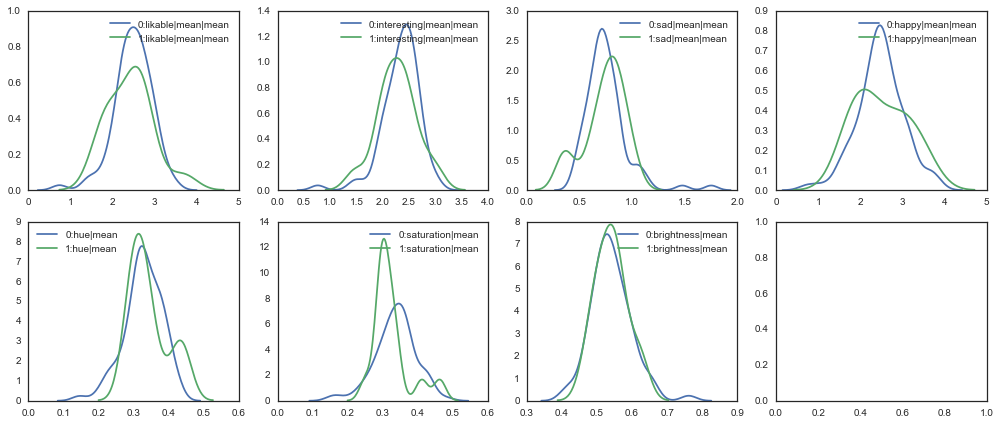

Correlation matrix:


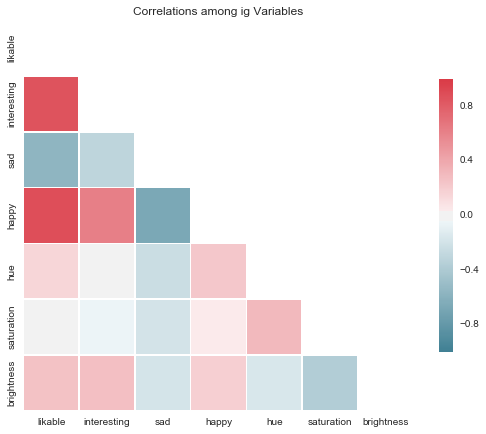

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.56   0.89  0.15       -0.01        0.26
interesting     0.86         1.00 -0.30   0.62  0.01       -0.05        0.28
sad            -0.56        -0.30  1.00  -0.67 -0.24       -0.19       -0.18
happy           0.89         0.62 -0.67   1.00  0.23        0.04        0.19
hue             0.15         0.01 -0.24   0.23  1.00        0.31       -0.16
saturation     -0.01        -0.05 -0.19   0.04  0.31        1.00       -0.36
brightness      0.26         0.28 -0.18   0.19 -0.16       -0.36        1.00
Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.862
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp username):
NAIVE ACCURACY: 0.586

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            17            8
known_target       

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


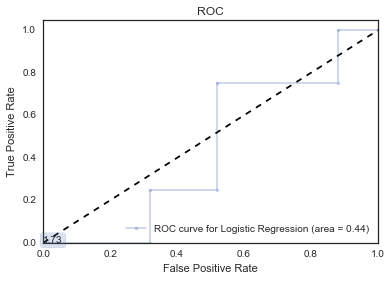

MODEL: Random Forests target (Models: after from_susp username):
NAIVE ACCURACY: 0.862

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            25            0
known_target              4            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




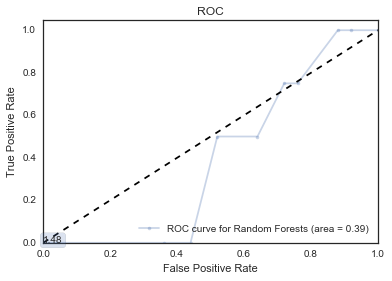

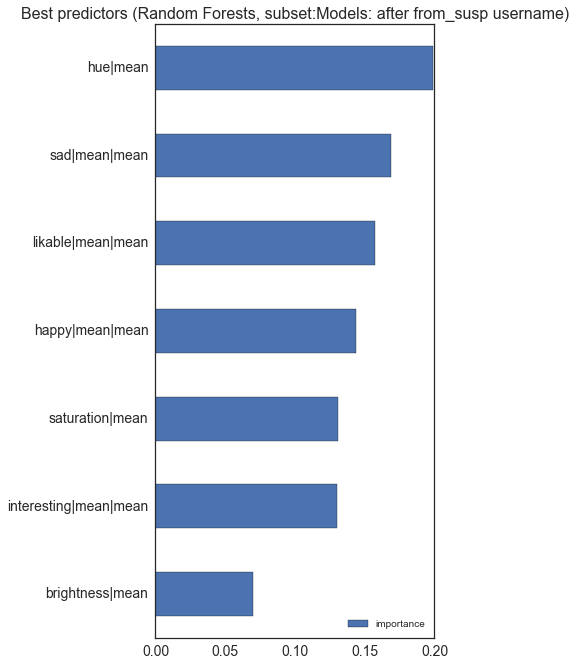

UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.47814145687178861, pvalue=0.63365965771442667)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.76571098578595453, pvalue=0.44576671926904798)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.29988916114609249, pvalue=0.76492385421239817)

RATING: happy|mean|mean
Ttest_indResult(statistic=-0.12918358976127228, pvalue=0.89748839507497946)

RATING: hue|mean
Ttest_indResult(statistic=-1.0034597143442932, pvalue=0.31821525444821952)

RATING: saturation|mean
Ttest_indResult(statistic=0.75723553612646277, pvalue=0.45080274180915125)

RATING: brightness|mean
Ttest_indResult(statistic=-0.05077271904115474, pvalue=0.95961436428682201)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (1.0)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean significant post-corre

In [8]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    for period in periods:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in turn_points:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{} {}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in gb_types:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, 
                               use_pca=use_pca) # using PCA!

### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [9]:
if final_pickle:
    pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point


before vs after (target: depression) for created_date-groupby, based on diag_date:


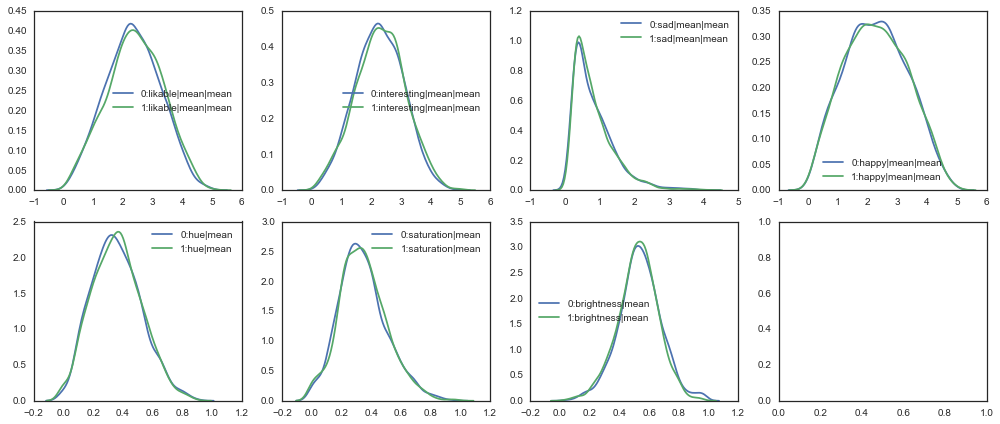

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=-2.317540079269369, pvalue=0.020525372426048259)

RATING: interesting|mean|mean
Ttest_indResult(statistic=-1.6322470262671029, pvalue=0.10270745073898813)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.55556889106904062, pvalue=0.57853717816565198)

RATING: happy|mean|mean
Ttest_indResult(statistic=-0.1959196749082773, pvalue=0.84468315109025516)

RATING: hue|mean
Ttest_indResult(statistic=-0.90489522760830243, pvalue=0.36557702086935862)

RATING: saturation|mean
Ttest_indResult(statistic=-1.0811294599180936, pvalue=0.27970665274804468)

RATING: brightness|mean
Ttest_indResult(statistic=3.3123868259217613, pvalue=0.00093349946034082683)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (0.143677606982)
interesting|mean|mean significant post-correction? False (0.718952155173)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|

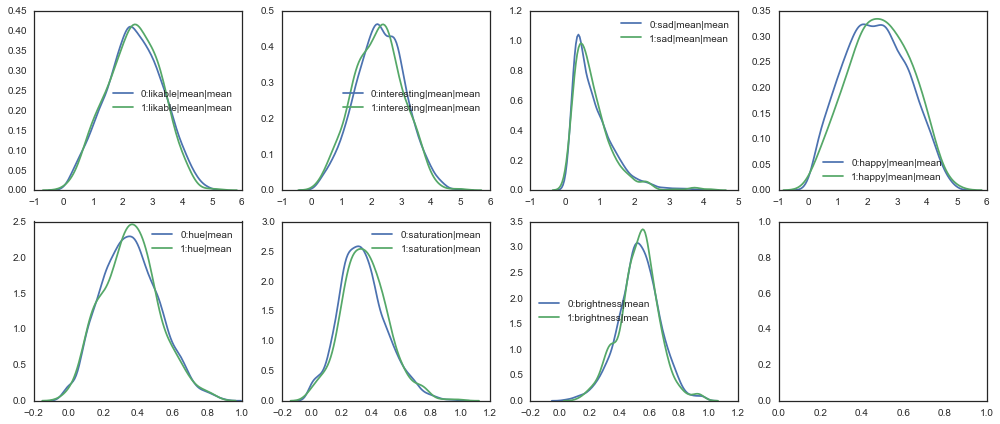

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=0.43192818122138471, pvalue=0.66581727106072308)

RATING: interesting|mean|mean
Ttest_indResult(statistic=1.8345169120027165, pvalue=0.066652738248376281)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.63948831034237141, pvalue=0.52254253193649791)

RATING: happy|mean|mean
Ttest_indResult(statistic=-2.5088129495827434, pvalue=0.01215364402999785)

RATING: hue|mean
Ttest_indResult(statistic=0.28615691113709912, pvalue=0.77477320554970674)

RATING: saturation|mean
Ttest_indResult(statistic=-1.9440002500581119, pvalue=0.05196754107113799)

RATING: brightness|mean
Ttest_indResult(statistic=0.4759212380151131, pvalue=0.63415725822775104)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (0.466569167739)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean significan

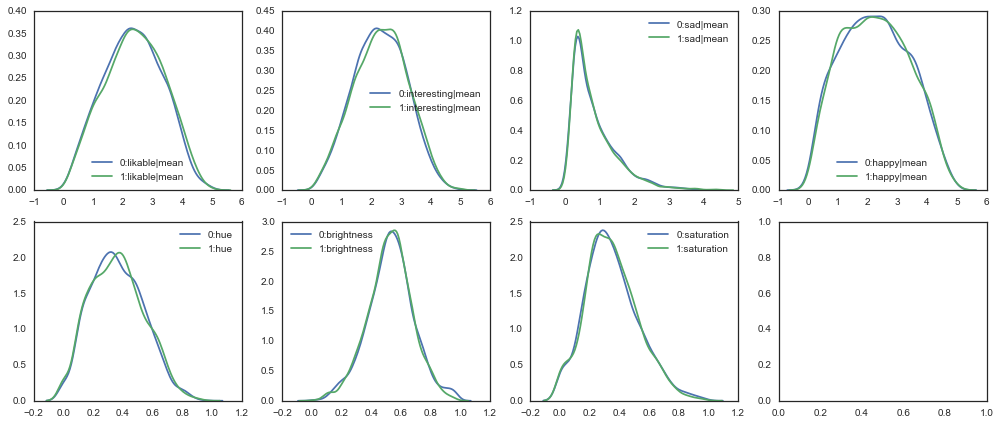

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=-2.3769707003364156, pvalue=0.017486255688012219)

RATING: interesting|mean
Ttest_indResult(statistic=-1.6003342441817596, pvalue=0.10957643477944445)

RATING: sad|mean
Ttest_indResult(statistic=0.29873830517466482, pvalue=0.76514994548477155)

RATING: happy|mean
Ttest_indResult(statistic=-0.33766507199521339, pvalue=0.73562726538844103)

RATING: hue
Ttest_indResult(statistic=-0.45413534480979917, pvalue=0.64974797163701781)

RATING: brightness
Ttest_indResult(statistic=1.6455699075563175, pvalue=0.099905130966330399)

RATING: saturation
Ttest_indResult(statistic=-0.18234840834365154, pvalue=0.85531552009364908)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (0.122403789816)
interesting|mean significant post-correction? False (0.767035043456)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? False (1.0)
hue significant 

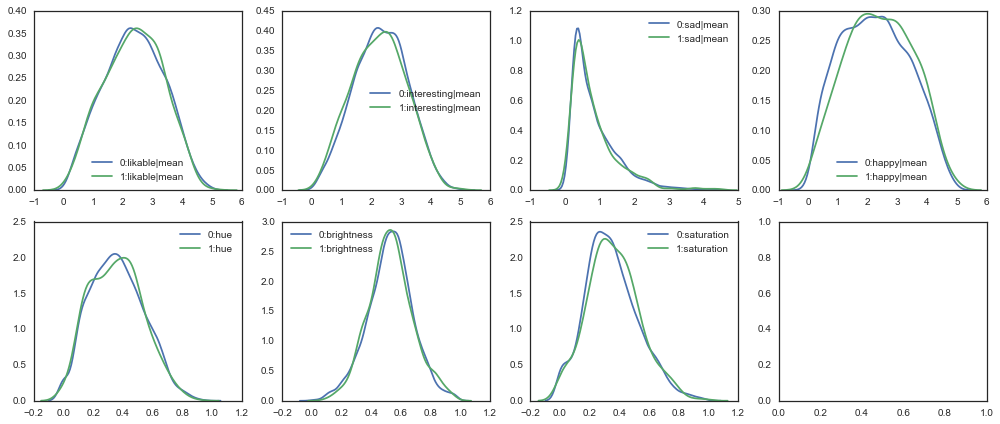

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=0.24201385394376548, pvalue=0.8087775946441953)

RATING: interesting|mean
Ttest_indResult(statistic=1.6145690329061948, pvalue=0.10645597171878945)

RATING: sad|mean
Ttest_indResult(statistic=0.1074604412929958, pvalue=0.91442725538151226)

RATING: happy|mean
Ttest_indResult(statistic=-3.040348530302337, pvalue=0.0023731137490821106)

RATING: hue
Ttest_indResult(statistic=0.95936370610581856, pvalue=0.33741451404881351)

RATING: brightness
Ttest_indResult(statistic=-0.49223945768604199, pvalue=0.62256822550306534)

RATING: saturation
Ttest_indResult(statistic=-1.5329355903554946, pvalue=0.12534486462903491)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (1.0)
interesting|mean significant post-correction? False (0.745191802032)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? True (0.0166117962436)
hue significant post-

In [10]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['created_date','post']: 
    before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: post

Total vars: 7
Num components selected by Minka MLE: 6
Cumulative % variance explained per component:
[ 36.13  56.48  70.6   82.72  92.9   98.19]


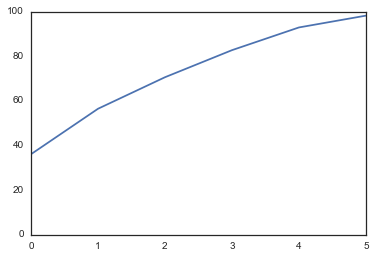

Num pca comp displayed: 6
Optimal number of components: 7
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


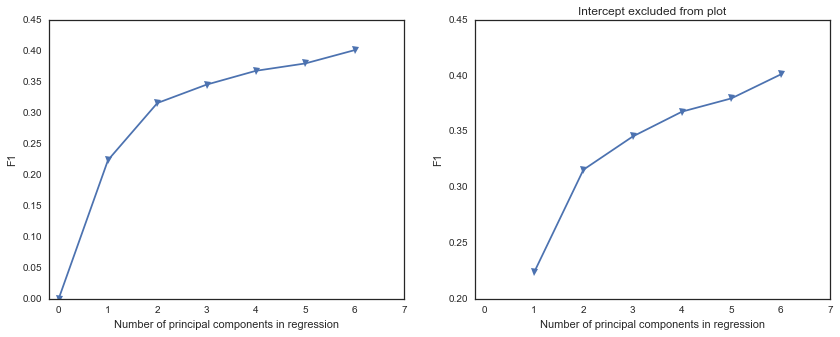

likable|mean        0.594661
happy|mean          0.556428
interesting|mean    0.510468
sad|mean            0.272737
brightness          0.042358
hue                 0.003054
saturation          0.000788
Name: PCA_0, dtype: float64

brightness          0.608117
saturation          0.589002
hue                 0.521701
sad|mean            0.099017
happy|mean          0.025594
interesting|mean    0.025158
likable|mean        0.002551
Name: PCA_1, dtype: float64

sad|mean            0.840058
interesting|mean    0.416320
brightness          0.230559
likable|mean        0.160466
saturation          0.143275
happy|mean          0.123474
hue                 0.079367
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.546
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: PCA MAIN post):
NAIVE ACCURACY: 0.562

CONFUSION MATRIX (lr):
        

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


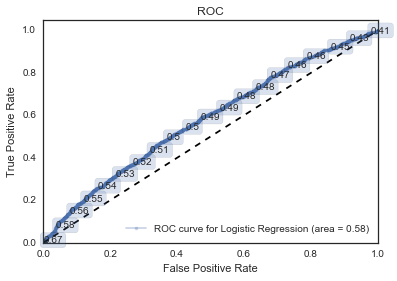

MODEL: Random Forests target (Models: PCA MAIN post):
NAIVE ACCURACY: 0.564

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1504          669
known_target           1067          741

Proportion of pred_target in known_control: 0.308
Proportion of pred_target in known_target: 0.41




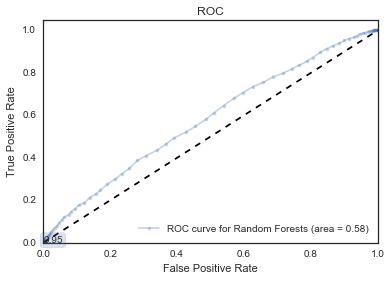

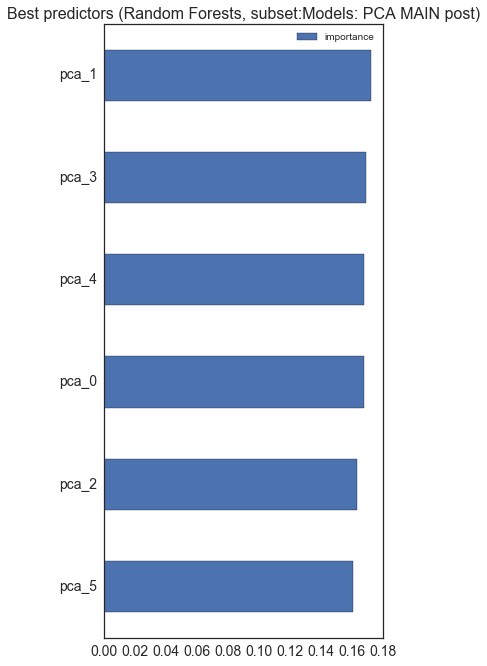

RUNNING PCA: created_date

Total vars: 7
Num components selected by Minka MLE: 6
Cumulative % variance explained per component:
[ 36.38  56.49  70.58  82.83  93.04  98.22]


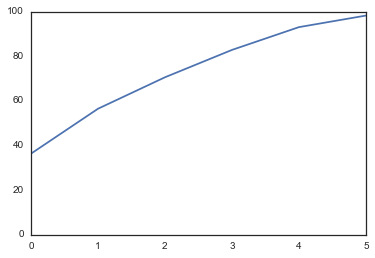

Num pca comp displayed: 6
Optimal number of components: 7
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


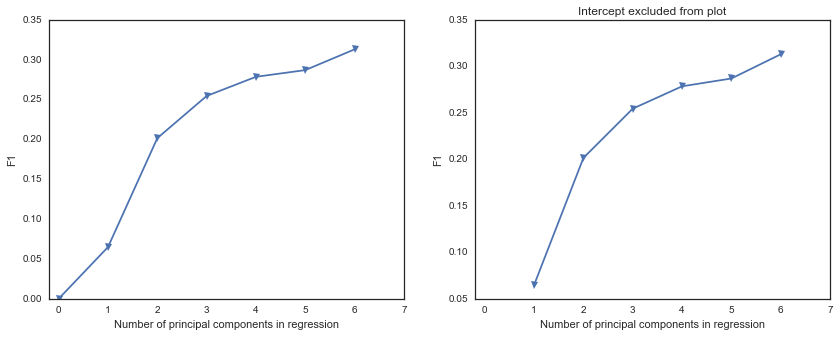

likable|mean|mean        0.593352
happy|mean|mean          0.556116
interesting|mean|mean    0.511144
sad|mean|mean            0.273540
brightness|mean          0.049061
saturation|mean          0.010364
hue|mean                 0.007819
Name: PCA_0, dtype: float64

brightness|mean          0.606697
saturation|mean          0.585708
hue|mean                 0.521602
sad|mean|mean            0.114706
happy|mean|mean          0.045404
interesting|mean|mean    0.039310
likable|mean|mean        0.005698
Name: PCA_1, dtype: float64

sad|mean|mean            0.828893
interesting|mean|mean    0.406194
brightness|mean          0.270907
saturation|mean          0.168286
likable|mean|mean        0.157494
happy|mean|mean          0.111578
hue|mean                 0.094753
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.565
  *'ALL NULL' means if all observations are predicted as uncompleted assessments




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


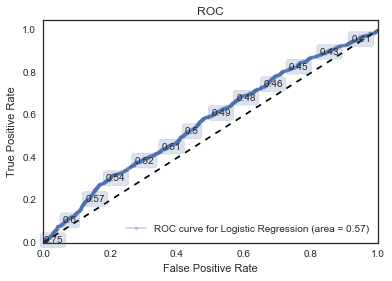

MODEL: Random Forests target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.574

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1102          431
known_target            725          455

Proportion of pred_target in known_control: 0.281
Proportion of pred_target in known_target: 0.386




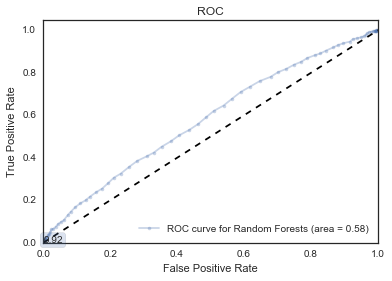

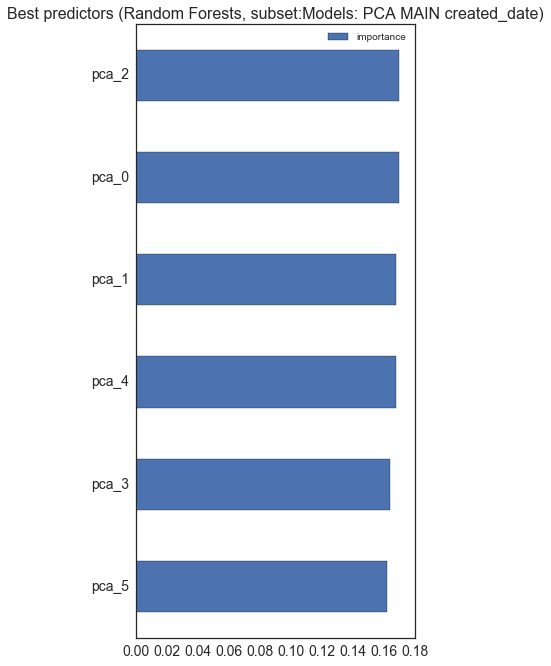

RUNNING PCA: username

Total vars: 7
Num components selected by Minka MLE: 6
Cumulative % variance explained per component:
[ 44.22  67.59  79.51  89.66  96.68  99.63]


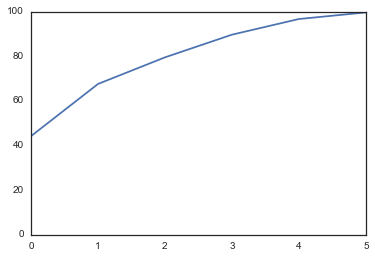

Num pca comp displayed: 6
Optimal number of components: 5


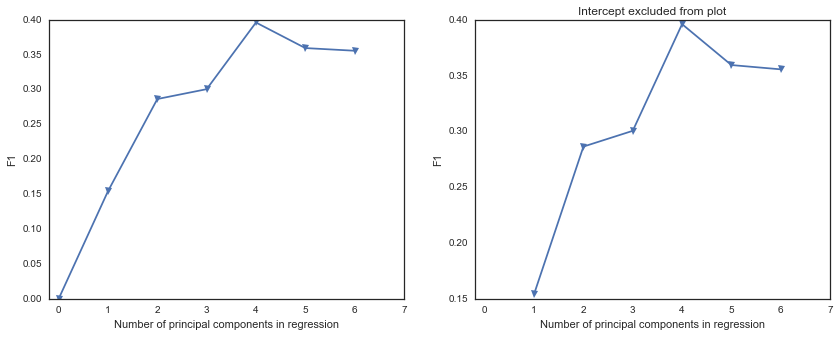

likable|mean|mean        0.546529
happy|mean|mean          0.522004
interesting|mean|mean    0.453445
sad|mean|mean            0.397796
brightness|mean          0.236100
saturation|mean          0.095847
hue|mean                 0.005815
Name: PCA_0, dtype: float64

saturation|mean          0.636881
hue|mean                 0.566474
brightness|mean          0.476027
sad|mean|mean            0.152716
happy|mean|mean          0.130763
likable|mean|mean        0.079926
interesting|mean|mean    0.008903
Name: PCA_1, dtype: float64

sad|mean|mean            0.634599
interesting|mean|mean    0.562338
brightness|mean          0.446495
likable|mean|mean        0.231614
saturation|mean          0.118836
hue|mean                 0.096263
happy|mean|mean          0.068324
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.55
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


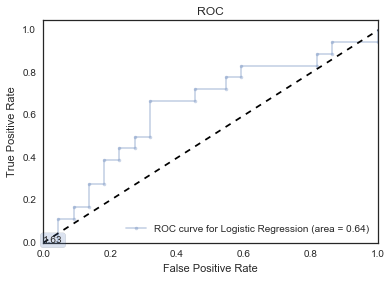

MODEL: Random Forests target (Models: PCA MAIN username):
NAIVE ACCURACY: 0.65

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            20            2
known_target             12            6

Proportion of pred_target in known_control: 0.091
Proportion of pred_target in known_target: 0.333




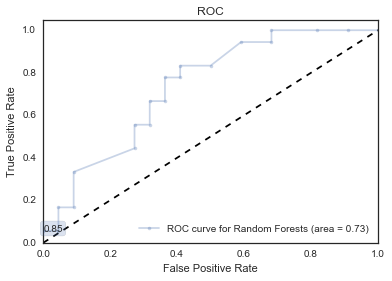

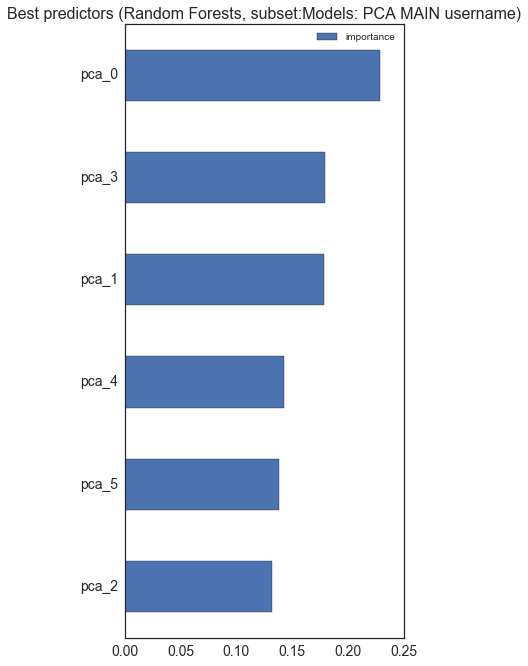

In [11]:
if run_separate_pca:
    master = data['master']
    report = 'PCA MAIN'

    for gb_type in gb_types:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'tall_plot':action_params['tall_plot']
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        _, pcafit = make_models(model_df, clf_types=clfs, excluded_set=excluded_set, 
                                tall_plot=model_df['tall_plot'], use_pca=True)